# MLP Project (T2 2023) by Ganesh P


`Disclaimer`   

>> This final notebook contains only the most relevant code to show the path/flow of my project work over few weeks. Rest of the code is in [my github repo](https://github.com/ganeshbmc/MLP_project) which is private at present (I will make it public after the project is over).  

`Overview`  

1.	> Screen the datasets and import them.  
2.	> Perform EDA (first round).
3.	> Data cleaning.
4.	> Basic models including dummy model.
5.	> Because this is a text sentiment analysis project, focus on 'reviewText' column, work on cleaning text data and vectorising/tokenising it, build several models till the best possible score is reached.
6.	> Merge train and movies dataset.
7.	> Perform EDA (second round) on merged dataset.
8.	> Data cleaning.
9.	> Build models on merged dataset.
10.	> Understand the results and do another round of EDA if needed.
11.	> Build final model.  


`Default code on Kaggle notebook`  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import remaining libraries  

In [20]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD

from scipy.stats import stats

print("Imports done.")

Imports done.


## Load datasets  

In [4]:
traindf = pd.read_csv("data/train.csv")
traindf.shape

(162758, 5)

In [5]:
testdf = pd.read_csv("data/test.csv")
testdf.shape

(55315, 4)

## Getting data ready for training and evaluating models  

`Handle missing data. Current strategy is to fill in some custom text.`  
`Separate features and labels from traindf`  
`Split training data into training and testing parts`

In [6]:
traindf.shape

(162758, 5)

In [7]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [8]:
traindf.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

### Fill empty reviewText with custom text  

In [9]:
traindf["reviewText"].fillna("empty", inplace=True)
traindf.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

### EDA  

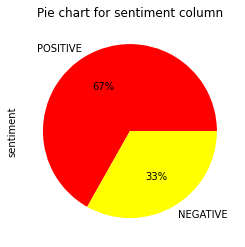

In [17]:
# Pie chart for sentiment column
plt.figure(figsize=(6, 4))
traindf["sentiment"].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])
plt.title("Pie chart for sentiment column")
plt.show()

In [23]:
# Chi-square test for isFrequentReviewer column and sentiment column   

contingency_table = pd.crosstab(traindf['isFrequentReviewer'], traindf['sentiment'])
print(contingency_table)
stats.chi2_contingency(contingency_table)


sentiment           NEGATIVE  POSITIVE
isFrequentReviewer                    
False                  35760     77429
True                   18237     31332


AttributeError: module 'scipy.stats.stats' has no attribute 'chi2_contingency'

### Separate features and labels  

In [10]:
train_features = traindf["reviewText"]
train_labels = traindf.iloc[:, -1]
train_features.shape, train_labels.shape

((162758,), (162758,))

### Split traindf into training and testing parts  

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((122068,), (40690,), (122068,), (40690,))

### Needs further exploration  

`stratify based on reviewer type?`  
`play with test size`  

## Model evaluation plan and code  

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [12]:
def evaluate(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    # print(f1_score(y_test, y_pred))
    ConfusionMatrixDisplay(y_test, y_pred)
    return

# Data preprocessing  

## Define stop words  

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [14]:
stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
type(stop_words), len(stop_words)

(list, 1160)

## Feature extraction  

### Understand CountVectorizer and TfidfVectorizer  

In [15]:
# text = X_train.copy()
# text.head()

In [16]:
# vectorizer = TfidfVectorizer(stop_words=stop_words)
# vectorized_text = vectorizer.fit_transform(text["reviewText"])
# vectorized_text

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.float64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.float64'>'
	with 1188395 stored elements in Compressed Sparse Row format>   

In [17]:
# vectorizer2 = CountVectorizer(stop_words=stop_words)
# vectorized_text2 = vectorizer2.fit_transform(text["reviewText"])
# vectorized_text2

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.int64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.int64'>'
	with 1188395 stored elements in Compressed Sparse Row format>

### Conclusion   
`TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.`  

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Model building workflow  

`Make pipeline for preprocesing and model training and predictions`  


In [18]:
from sklearn.pipeline import Pipeline

In [19]:
def preprocess_n_train(X_train, y_train, preprocessor, model):
    pipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("model", model)
                        ])
    
    pipe.fit(X_train, y_train)

    print("Given model has been trained. Use predict method to get predictions array.")
    return pipe


def predict_n_evaluate(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    print(f"y_pred shape: {y_pred.shape}")
    print(f"Summary of predictions: {np.unique(y_pred, return_counts=True)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return y_pred

# def evaluate(y_test, y_pred):
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     # print(f1_score(y_test, y_pred))
#     ConfusionMatrixDisplay(y_test, y_pred)
#     return

## Preprocessor(s)  

In [20]:
# tvec = TfidfVectorizer()
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

## Logistic Regression with TfidVectorizer for preprocessing  

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
# logreg = LogisticRegression(max_iter=1000)
# logreg

In [23]:
# tvec = TfidfVectorizer()
# cvec = CountVectorizer()        # Note that TfidfVectorizer and CountVectorizer+TfidsTransformer do the same function
# tvec, cvec

In [24]:
# logreg_pipe = preprocess_n_train(X_train, y_train, tvec, logreg)
# logreg_pipe

In [25]:
# y_pred_logreg = predict_n_evaluate(logreg_pipe, X_test, y_test)
# y_pred_logreg

### Logistic Regression with stop words  

In [26]:
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

In [27]:
# logreg_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, logreg)
# logreg_sw_pipe

In [28]:
# y_pred_logreg_sw = predict_n_evaluate(logreg_sw_pipe, X_test, y_test)
# y_pred_logreg_sw

### Logistic regression with different ngram ranges  

#### ngram range (1,2)  

In [29]:
# tvec_ngram_2 = TfidfVectorizer(ngram_range=(1,2))

In [30]:
# logreg_ng2_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2, logreg)
# logreg_ng2_pipe

In [31]:
# y_pred_logreg_ng2 = predict_n_evaluate(logreg_ng2_pipe, X_test, y_test)
# y_pred_logreg_ng2

### Logistic regression with C=2, ngram range (1,2), stop words as None and min_df, max_df adjusted
### Class weight balanced

In [32]:
# logreg = LogisticRegression(max_iter=100000, C=2, class_weight="balanced")

In [33]:
# tvec_ngram_2_sw_df = TfidfVectorizer(ngram_range=(1,2), stop_words=None, min_df=0.0001, max_df=0.50)
# tvec_ngram_2_sw_df

In [34]:
# logreg_ng2_sw_df_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2_sw_df, logreg)
# logreg_ng2_sw_df_pipe

In [35]:
# y_pred_logreg_ng2_sw_df = predict_n_evaluate(logreg_ng2_sw_df_pipe, X_test, y_test)
# y_pred_logreg_ng2_sw_df

## Log reg with parameters from GridSearchCV  

`This is the best score with "reviewText column alone for analysis`  

In [36]:
# logreg_cv1 = LogisticRegression(max_iter=100000, C=10)
# tvec_cv1 = TfidfVectorizer(max_features=None, ngram_range=(1,2))

In [37]:
# pipe_cv1 = Pipeline(steps=[
#     ("preprocessor", tvec_cv1),
#     ("model", logreg_cv1)
# ])

In [38]:
# pipe_cv1.fit(X_train, y_train)

## SVM model  

In [39]:
# from sklearn.svm import LinearSVC

In [40]:
# svm = LinearSVC()
# svm

In [41]:
# svm_pipe = preprocess_n_train(X_train, y_train, tvec, svm)
# svm_pipe

In [42]:
# y_pred_svm = predict_n_evaluate(svm_pipe, X_test, y_test)
# y_pred_svm

### SVM model with stop words  

In [43]:
# svm_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, svm)
# svm_sw_pipe

In [44]:
# y_pred_svm_sw = predict_n_evaluate(svm_sw_pipe, X_test, y_test)
# y_pred_svm_sw

## Naive Bayes model  

### MultinomialNB  

In [45]:
# from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB

In [46]:
# mnb = MultinomialNB()
# mnb

In [47]:
# mnb_pipe = preprocess_n_train(X_train, y_train, tvec, mnb)
# mnb_pipe

In [48]:
# y_pred_mnb = predict_n_evaluate(mnb_pipe, X_test, y_test)
# y_pred_mnb

### GaussianNB  

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [49]:
# gnb = GaussianNB()
# gnb

In [50]:
# gnb_pipe = preprocess_n_train(X_train, y_train, tvec, gnb)
# gnb_pipe

## Submitting predictions to Kaggle competition  

In [51]:
# def submit(selected_model=logreg, selected_preprocessor=tvec):
    
#     # Retrain on the whole train.csv file  
#     traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
#     X_train = traindf["reviewText"]
#     X_train.fillna("empty", inplace=True)
#     y_train = traindf["sentiment"]
#     pipe = preprocess_n_train(X_train, y_train, selected_preprocessor, selected_model)
    
#     # Predict on test.csv file
#     testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
#     X_test = testdf["reviewText"]
#     X_test.fillna("empty", inplace=True)
    
#     y_pred = pipe.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

In [52]:
# submit(logreg_cv1, tvec_cv1)

## Part 2: Merge "movies.csv" with "train.csv" to see if score improves  

### Custom functions  

In [53]:
def load_csv(filename: str):
    df = pd.read_csv(f"/kaggle/input/sentiment-prediction-on-movie-reviews/{filename}.csv")
    return df

In [54]:
def inspect(df: pd.DataFrame):
    print(f"Shape of the dataframe: {df.shape}")
    print()
    print(f"Columns in the dataframe:\n{df.columns}")
    print()
    print(f"{df.info()}")
    print()
    # print(f"Summary: {df.describe()}")
    print(f"Missing values:\n{df.isna().sum()}")
    return

In [55]:
def select_features(df: pd.DataFrame, moviesdf: pd.DataFrame):
    '''
    This function merges the given dataframes. Note that the first df must be "train" or "test" and
    the second df should be "movies".
    Note: Sentiment column is present only in "train.csv" file and not "test.csv" file.
    '''
    
    # Drop duplicates from moviesdf
    movies_unique = moviesdf.drop_duplicates(subset=["movieid"])

    # Merge df and movies_unique
    df_merged = pd.merge(df, movies_unique, on="movieid")
    
    # Rename "isTopCritic" column, if it exists, to "isFrequentReviewer"
    df_merged.rename(columns={"isTopCritic": "isFrequentReviewer"}, inplace=True)
    
    # Drop columns
    df_merged = df_merged.drop(columns=["title", "ratingContents", "releaseDateTheaters", "releaseDateStreaming", "boxOffice", "distributor", "soundType"])

    # Fill missing values in "reviewText" with empty string
    final = df_merged.copy()
    final["reviewText"] = final["reviewText"].fillna("")
    
    # Fill missing values in "rating", "genre", original columns with the word "Unknown"
    final["rating"] = final["rating"].fillna("Unknown")
    final["genre"] = final["genre"].fillna("Unknown")
    final["originalLanguage"] = final["originalLanguage"].fillna("Unknown")

    # Impute missing values for "audienceScore" and "runtimeMinutes" columns
    final["audienceScore"] = final["audienceScore"].fillna(final["audienceScore"].mean())
    final["runtimeMinutes"] = final["runtimeMinutes"].fillna(final["runtimeMinutes"].mean())
    
    # Clean language names
    final["originalLanguage"].replace({"English (United Kingdom)": "English", 
                                            "English (Australia)" : "English",
                                            "French (France)": "French", 
                                            "French (Canada)": "French",
                                            "Portuguese (Brazil)": "Portuguese",
                                            "Spanish (Spain)": "Spanish"},                                         
                                            inplace=True)

    return final

In [56]:
def split_train_predict(features, labels, pipeline, test_size=0.25, random_state=42):
    # cols = features.columns
    if len(features.shape) == 1:
        features = features.to_numpy().reshape(-1, 1)  # reshape to 2D array
    features = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return pipeline

### Merge "train.csv" file with "movies.csv" file  

In [57]:
merged = select_features(load_csv("train"), load_csv("movies"))
inspect(merged)

Shape of the dataframe: (162758, 11)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   reviewerName        162758 non-null  object 
 2   isFrequentReviewer  162758 non-null  bool   
 3   reviewText          162758 non-null  object 
 4   sentiment           162758 non-null  object 
 5   audienceScore       162758 non-null  float64
 6   rating              162758 non-null  object 
 7   runtimeMinutes      162758 non-null  float64
 8   genre               162758 non-null  object 
 9   originalLanguage    162758 non-null  object 
 10  director     

## EDA  

In [ ]:
## Box plot audienceScore and sentiment  
plt.figure(figsize=(6, 4))
sns.boxplot(x="sentiment", y="audienceScore", data=merged)
plt.title("Box plot audienceScore and sentiment")
plt.show()


In [ ]:
## Bar plot for sentiment and genre columns
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", hue="genre", data=merged)
plt.title("Bar plot for sentiment and genre columns")
plt.show()

In [ ]:
## Column chart for sentiment and rating columns
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", hue="rating", data=merged)
plt.title("Column chart for sentiment and rating columns")
plt.show()


In [25]:
# Correlation heatmap  
plt.figure(figsize=(10, 8))
sns.heatmap(merged.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

NameError: name 'merged' is not defined

<Figure size 720x576 with 0 Axes>

### Separate features and labels from merged dataset  

In [58]:
merged_train_features = merged[['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director']]
merged_train_features.shape

(162758, 10)

In [59]:
merged_train_labels = merged["sentiment"]
merged_train_labels.shape

(162758,)

### Identify variable types for different preprocessing pipes  

In [60]:
num_vars = ["audienceScore", "runtimeMinutes"]
txt_vars = ["originalLanguage", "genre", "director", "reviewerName", "reviewText"]
cat_vars = ["rating", "isFrequentReviewer"]

In [61]:
num_pipe = Pipeline(steps=[
                            ("imputer", SimpleImputer(strategy="mean", missing_values=np.nan)),
                            ("scaler", MinMaxScaler())
                        ])
num_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [62]:
txt_pipe = Pipeline(steps=[
                            ("tvec", TfidfVectorizer())
                        ])
txt_pipe

Pipeline(steps=[('tvec', TfidfVectorizer())])

In [63]:
cat_pipe = Pipeline(steps=[
                            ("ohe", OneHotEncoder(handle_unknown="ignore"))
                        ])
cat_pipe

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [64]:
ct_final = ColumnTransformer(transformers=[
                                        ("num", num_pipe, num_vars),
                                        ("txt1", txt_pipe, "originalLanguage"),
                                        ("txt2", txt_pipe, "genre"),
                                        ("txt3", txt_pipe, "director"),
                                        ("cat", cat_pipe, cat_vars),
                                        ("txt4", TfidfVectorizer(ngram_range=(1,2)), "reviewText"),
#                                         ("cat2", cat_pipe, ["isFrequentReviewer"])
                                        ], remainder="drop", n_jobs=1)

# Note that this transformer drops "movieid" column and "reviewerName" column  
ct_final

ColumnTransformer(n_jobs=1,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['audienceScore', 'runtimeMinutes']),
                                ('txt1',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'originalLanguage'),
                                ('txt2',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'genre'),
                                ('txt3',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'director'),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['rating', 'isFrequentReviewer']),
                                ('txt4', TfidfVectorizer(ngram_range=(1, 2)),
                                 'reviewText')])

In [65]:
pipe_final = Pipeline(steps=[
                        ("preprocessor", ct_final),
                        ("model", LogisticRegression(max_iter=100000))
                    ])
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['audienceScore',
                                                   'runtimeMinutes']),
                                                 ('txt1',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'originalLanguage'),
                                                 ('txt2',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'genre'),
                                                 ('txt3',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'director'),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating',
                                                   'isFrequentReviewer']),
                                                 ('txt4',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', LogisticRegression(max_iter=100000))])

In [66]:
final_vars = num_vars + txt_vars + cat_vars
len(final_vars), final_vars

(9,
 ['audienceScore',
  'runtimeMinutes',
  'originalLanguage',
  'genre',
  'director',
  'reviewerName',
  'reviewText',
  'rating',
  'isFrequentReviewer'])

In [67]:
# split_train_predict(merged_train_features, merged_train_labels, pipe_final, test_size=0.25, random_state=42)

### Merge and preprocess "test.csv" and "movies.csv" files  

In [68]:
merged_test = select_features(load_csv("test"), load_csv("movies"))
inspect(merged_test)

Shape of the dataframe: (55315, 10)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieid             55315 non-null  object 
 1   reviewerName        55315 non-null  object 
 2   isFrequentReviewer  55315 non-null  bool   
 3   reviewText          55315 non-null  object 
 4   audienceScore       55315 non-null  float64
 5   rating              55315 non-null  object 
 6   runtimeMinutes      55315 non-null  float64
 7   genre               55315 non-null  object 
 8   originalLanguage    55315 non-null  object 
 9   director            55315 non-null  object 
dtypes: bool(1), float64(2), object(7)
memory 

## Try the best four features obtained on local machine  

In [69]:
ct_best4 = ColumnTransformer(transformers=[
    ("num", num_pipe, ["audienceScore"]),
    ("cat", cat_pipe, ["rating", "isFrequentReviewer"]),
    ("tvec", TfidfVectorizer(ngram_range=(1,2)), "reviewText")
])

pipe_best4 = Pipeline(steps=[
    ("preprocessor", ct_best4),
    ("model", LogisticRegression())
])

pipe_best4.set_params(model__C=10, model__max_iter=100000)

pipe_best4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['audienceScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating',
                                                   'isFrequentReviewer']),
                                                 ('tvec',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', LogisticRegression(C=10, max_iter=100000))])

In [70]:
# split_train_predict(merged[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]], merged["sentiment"], pipe_best4, test_size=0.25)

## Submit_v2 for merged file models

In [71]:
def submit_v2(selected_model=pipe_final):
    '''
    Note that "selected_preprocessor" is already used within selected_model or pipeline
    '''
    # Retrain on the whole train.csv file  
    merged = select_features(load_csv("train"), load_csv("movies"))
    X_train = merged.drop(labels="sentiment", axis=1)
    y_train = merged["sentiment"]
    selected_model.fit(X_train, y_train)
    
    # Predict on test.csv file
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    X_test = merged_test.copy()
    
    y_pred = selected_model.predict(X_test)
    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    return "Successfully created the submission file!!!"

In [72]:
# submit_v2(pipe_best4)

## submit_v3 for merged file models - does not retrain on whole data  

In [73]:
# Incomplete! 
def submit_v3(selected_model=pipe_final):
    '''
    Note that "selected_preprocessor" is already used within selected_model or pipeline
    '''
    # Train on merged file
    merged = select_features(load_csv("train"), load_csv("movies"))
    X_train = merged.drop(labels="sentiment", axis=1)
    y_train = merged["sentiment"]
    pipe = split_train_predict(merged[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]], merged["sentiment"], selected_model, test_size=0.25)
    
    # Predict on test.csv file
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    X_test = merged_test.copy()
    
    y_pred = pipe.predict(X_test)    # This line is different from submit__v2
    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    return "Successfully created the submission file!!!"

In [74]:
submit_v3(selected_model=pipe_best4)

              precision    recall  f1-score   support

    NEGATIVE       0.79      0.67      0.73     13717
    POSITIVE       0.84      0.91      0.88     26973

    accuracy                           0.83     40690
   macro avg       0.82      0.79      0.80     40690
weighted avg       0.83      0.83      0.83     40690

[[ 9161  4556]
 [ 2388 24585]]


'Successfully created the submission file!!!'

## Implement KNN classifier  

In [75]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:
# Note that we are borrowing "ct_final" column transformer from above  

In [77]:
pipe_knn = Pipeline(steps=[
                        ("preprocessor", ct_final),
                        ("model", KNeighborsClassifier())
                    ])
pipe_knn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['audienceScore',
                                                   'runtimeMinutes']),
                                                 ('txt1',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'originalLanguage'),
                                                 ('txt2',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'genre'),
                                                 ('txt3',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'director'),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating',
                                                   'isFrequentReviewer']),
                                                 ('txt4',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', KNeighborsClassifier())])

In [78]:
# Train and predict on merged training data  
# split_train_predict(merged_train_features, merged_train_labels, pipe_knn, test_size=0.25, random_state=42)